# Packages & Data

In [1]:
import pandas as pd
from copy import deepcopy
import geopy.distance
from sklearn import metrics
from iteration_utilities import deepflatten
from tqdm import tqdm_notebook as tqdm
import math
from os.path import join
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pylab 
from numpy import percentile
import joblib
from numpy import mean
from numpy import std
from statistics import mean
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [2]:
# apartments kleineinzeigen doesn't have year constructed

apartments_immonet = pd.read_excel("immonetApartments.xlsx")
houses_immonet = pd.read_excel("immonetHouses.xlsx")
apartments_kleineinzeigen = pd.read_excel("kleineinzeigenApartments.xlsx")
houses_kleineinzeigen = pd.read_excel("kleineinzeigenHouses.xlsx")

In [3]:
apartments_immonet['Year Constructed'] = pd.to_numeric(apartments_immonet['Year Constructed'], errors='coerce').astype('Int64')
houses_immonet['Year Constructed'] = pd.to_numeric(houses_immonet['Year Constructed'], errors='coerce').astype('Int64')
houses_kleineinzeigen['Year Constructed'] = pd.to_numeric(houses_kleineinzeigen['Year Constructed'], errors='coerce').astype('Int64')

apartments_immonet.drop(columns='Year Constructed', inplace=True)
houses_immonet.drop(columns='Year Constructed', inplace=True)
houses_kleineinzeigen.drop(columns='Year Constructed', inplace=True)

# Preprocessing

## Data Management

In [4]:
apartments_immonet['Floor Level'].loc[
    apartments_immonet['Floor Level'].apply(lambda x: x > 99 if isinstance(x, float) else False)
] = np.nan

apartments_kleineinzeigen['Floor Level'].loc[
    apartments_kleineinzeigen['Floor Level'].apply(lambda x: x > 99 if isinstance(x, float) else False)
] = np.nan

In [5]:
def zip_modifier(df):
    new_vals = []
    for row in df["Zip Code"]:
        if len(str(row)) < 5:
            new_vals.append(row*100)
        else:
            new_vals.append(row*10)
    df["Zip Code"] = new_vals

In [7]:
# Handle cases where zip has 4 digits instead of 5

zip_modifier(apartments_immonet)
zip_modifier(houses_immonet)
# zip_modifier(apartments_engel)
# zip_modifier(houses_engel)
zip_modifier(apartments_kleineinzeigen)
zip_modifier(houses_kleineinzeigen)

## Outlier Removal 

In [8]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [9]:
def normalize_columnwise(data):
    for i in data.columns:
        data[i]=((data[i]-np.nanmin(data[i].values))/(np.nanmax(data[i].values)-np.nanmin(data[i].values)))
    return data

def sample_first_prows(data, perc=0.3):
    return data.head(int(len(data)*(perc)))

In [10]:
titles_apartments = list(set(apartments_immonet.drop(columns=['Link', 'Transportation Availability Rating', 'Basic Neccessities Rating', 'Longitude', 'Latitude', 'Floor Level', 'Elevator', 'Storage', 'Balcony', 'Zip Code'], axis=1).columns.tolist()))
titles_houses = list(set(houses_immonet.drop(columns=['Link', 'House Type', 'Transportation Availability Rating', 'Basic Neccessities Rating', 'Longitude', 'Latitude', 'Parking', 'Terrace', 'Zip Code'], axis=1).columns.tolist()))

# Outlier removal 95/5 quantiles
def outlier_removal(df, titles):
    outliers_info = []

    for title in tqdm(titles):
        # Handle NaN values when calculating percentiles
        q10, q90 = np.nanpercentile(df[title].dropna(), 15), np.nanpercentile(df[title].dropna(), 85)
        iqr = q90 - q10
    
        cut_off = iqr * 1.5
        lower, upper = q10 - cut_off, q90 + cut_off
    
        # Handle NaN values when checking conditions for outliers
        outliers_indices = df[df[title].isna() | (df[title] < lower) | (df[title] > upper)].index
        outliers_info.append({'title': title, 'outliers_count': len(outliers_indices)})
    
        if len(outliers_indices) > 0:
            print(f'Identified outliers for {title}: {len(outliers_indices)}')
            df = df.loc[df.index.difference(outliers_indices)]#.reset_index(drop=True)

    return df

In [11]:
apartments_immonet_no_outliers = outlier_removal(apartments_immonet, titles_apartments)

  0%|          | 0/3 [00:00<?, ?it/s]

Identified outliers for Room Count: 361
Identified outliers for Interior Size: 137
Identified outliers for Price: 145


In [12]:
apartments_kleineinzeigen_no_outliers = outlier_removal(apartments_kleineinzeigen, titles_apartments)

  0%|          | 0/3 [00:00<?, ?it/s]

Identified outliers for Room Count: 856
Identified outliers for Interior Size: 108
Identified outliers for Price: 555


In [13]:
houses_immonet_no_outliers = outlier_removal(houses_immonet, titles_houses)

  0%|          | 0/5 [00:00<?, ?it/s]

Identified outliers for Interior Size: 41
Identified outliers for Price: 26
Identified outliers for Floor Count: 16
Identified outliers for Room Count: 11
Identified outliers for Exterior Size: 161


In [14]:
houses_kleineinzeigen_no_outliers = outlier_removal(houses_kleineinzeigen, titles_houses)

  0%|          | 0/5 [00:00<?, ?it/s]

Identified outliers for Interior Size: 244
Identified outliers for Price: 284
Identified outliers for Floor Count: 1706
Identified outliers for Room Count: 13
Identified outliers for Exterior Size: 579


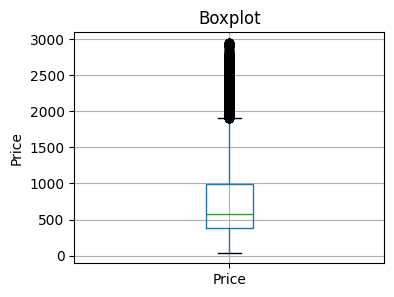

In [271]:
plt.figure(figsize=(4, 3))  # Adjust the figure size if needed
apartments_immonet_no_outliers.boxplot(column=['Price'])
plt.title('Boxplot')
plt.ylabel('Price')
plt.show()

## Impute Median 

In [15]:
apartments_immonet_no_outliers.drop(columns=['Link', 'Transportation Availability Rating', 'Basic Neccessities Rating'], axis=1, inplace=True)
apartments_kleineinzeigen_no_outliers.drop(columns=['Link'], axis=1, inplace=True)
houses_immonet_no_outliers.drop(columns=['Link', 'Transportation Availability Rating', 'Basic Neccessities Rating', 'House Type'], axis=1, inplace=True)
houses_kleineinzeigen_no_outliers.drop(columns=['Link','House Type'], axis=1, inplace=True)

In [16]:
apartments_immonet_no_outliers[apartments_immonet_no_outliers.columns[apartments_immonet_no_outliers.isna().any()]] = apartments_immonet_no_outliers[apartments_immonet_no_outliers.columns[apartments_immonet_no_outliers.isna().any()]].fillna(apartments_immonet_no_outliers.median())

apartments_kleineinzeigen_no_outliers[apartments_kleineinzeigen_no_outliers.columns[apartments_kleineinzeigen_no_outliers.isna().any()]] = apartments_kleineinzeigen_no_outliers[apartments_kleineinzeigen_no_outliers.columns[apartments_kleineinzeigen_no_outliers.isna().any()]].fillna(apartments_kleineinzeigen_no_outliers.median())

houses_immonet_no_outliers[houses_immonet_no_outliers.columns[houses_immonet_no_outliers.isna().any()]] = houses_immonet_no_outliers[houses_immonet_no_outliers.columns[houses_immonet_no_outliers.isna().any()]].fillna(houses_immonet_no_outliers.median())

houses_kleineinzeigen_no_outliers[houses_kleineinzeigen_no_outliers.columns[houses_kleineinzeigen_no_outliers.isna().any()]] = houses_kleineinzeigen_no_outliers[houses_kleineinzeigen_no_outliers.columns[houses_kleineinzeigen_no_outliers.isna().any()]].fillna(houses_kleineinzeigen_no_outliers.median())

In [19]:
apartments_kleineinzeigen_no_outliers.to_excel('apartments_kleineinzeigen_no_outliers.xlsx', index=False)
houses_kleineinzeigen_no_outliers.to_excel('houses_kleineinzeigen_no_outliers.xlsx', index=False)

## Concatenate Datasets

In [281]:
apartments_no_outliers_concatenated = pd.concat([apartments_immonet_no_outliers, apartments_kleineinzeigen_no_outliers], ignore_index=True)
houses_no_outliers_concatenated = pd.concat([houses_immonet_no_outliers, houses_kleineinzeigen_no_outliers], ignore_index=True)

## Store

In [288]:
apartments_no_outliers_concatenated.to_excel('apartments_no_outliers_concatenated.xlsx', index=False)
houses_no_outliers_concatenated.to_excel('houses_no_outliers_concatenated.xlsx', index=False)